# Custom ES for optimizing RVCGP

- [Tournament selection](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian)
- [Arithmetic (blend) crossover](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian)
- [Gaussian mutation](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian)

First let's define environment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tengp
import numpy as np
from gpbenchmarks import get_data
from sklearn.metrics import mean_squared_error
import random


def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

def plog(x, _):
    return np.log(x, out=np.copy(x), where=x>0)

def psin(x, _):
    return np.sin(x)

def pcos(x, _):
    return np.cos(x)

def pow2(x):
    return x**2

def pow3(x):
    return x**3


funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)

X, y = get_data('nguyenf4', 20, -1, 1)
X = np.c_[np.ones(len(X)), X]

rv_params = tengp.Parameters(2, 1, 1, 10, funset, real_valued=True)
params = tengp.Parameters(2, 1, 1, 10, funset, real_valued=False)

builder = tengp.individual.IndividualBuilder(rv_params)
bounds = builder.create().bounds[:]
genotypes = []

In [2]:
def clip(rv_genes, bounds):
    clipped = []
    for gene, bound in zip(rv_genes, bounds):
        if gene < 0:
            clipped.append(0)
        elif gene > bound:
            clipped.append(bound)
        else:
            clipped.append(gene)
    return clipped

def cost_function(individual):
    #individual = tengp.individual.NPIndividual(clip(rv_genes, bounds), bounds, rv_params)
    
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
        
 #   genotypes.append((scaled, out))
    return out

In [19]:
import math

def bound(x, a, b):
    return a + (b - a) * ( 1 - np.cos(np.pi * x/10))/2

def scale_a(x, a, b):
    return a + (b - a) * x / 10

def scale_b(x, a, b):
    return a + (b - a) * (x/10)**2

def scale_c(x, a, b):
    return a *(b/a)**(x/10)

def cost_function_cma(rv_genes):
    bounded = bound(np.array(rv_genes), 0, 10)   
    scaled = [scale_a(x, 0, b) for x, b in zip(bounded, bounds)]
    individual = tengp.individual.NPIndividual(scaled, bounds, rv_params)
    
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
        
 #   genotypes.append((scaled, out))
    return out

In [20]:
def plot_results(outs):
    costs = np.array(outs)
    print('mean:', np.mean(costs))
    print('median:', np.median(costs))
    print('variance:',np.var(costs))
    print('min:', np.min(costs))
    sns.distplot(costs);

Optimization with L-BFGS-B, only the parameters are scaled.

In [21]:
from scipy.optimize import minimize

random.seed(42)

minimize(cost_function_cma, [random.uniform(0, 10) for _ in bounds], method='L-BFGS-B', bounds=[(0, 10) for b in bounds], options={'eps': 1})

      fun: 3.4374309936883081
 hess_inv: <31x31 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02907274,
        0.01038732, -0.00159615,  0.00022597,  0.00011176,  0.00011176,
        0.00010491])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1376
      nit: 2
   status: 2
  success: False
        x: array([  8.69745526,   0.45859927,   3.64375865,   2.54033899,
         7.65324414,   7.10188473,   8.92179568,   0.86938833,
         4.2192182 ,   0.29758217,   2.18407142,   5.05313883,
         1.81949598,   7.57311652,   6.76361285,   5.4507768 ,
         2.22226166,   5.89694545,   9.64273767,   0.50160644,
         9.5901334

Set up a simple base line. Classic CGP, simple ES, point mutation

In [4]:
random.seed(42)
simple_es_results = []
for i in range(100):
    print(i, end=', ')
    out = tengp.simple_es(X, y, mean_squared_error, params, mutation='point')
    simple_es_results.append(out)

0, 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:164: RuntimeWarning: invalid value encountered in multiply
  current_node.value = current_node.fun(*values)
/home/jarino/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


1, 2, 

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:164: RuntimeWarning: invalid value encountered in add
  current_node.value = current_node.fun(*values)
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:164: RuntimeWarning: invalid value encountered in subtract
  current_node.value = current_node.fun(*values)


3, 4, 5, 6, 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

mean: 0.0900826103325606
median: 0.040966064449306165
variance: 0.01896381681025809
min: 4.1648235047373975e-33


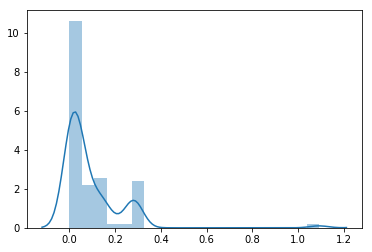

In [5]:
plot_results([x[0].fitness for x in simple_es_results])

First of all, let's try a really dumb hillclimber. It just randomly picks a gene and randomly changes its value.

In [6]:
class Individual():
    def __init__(self, genes):
        self.genes = genes
        self.fitness = None
        
    def __repr__(self):
        return f'Ind: {self.fitness}'

In [7]:
random.seed(42)

indices = list(range(len(bounds)))
res = []

for trial in range(100):
    print(trial, end=', ')
    
    population = [Individual([random.uniform(0, b) for b in bounds]) for _ in range(5)]

    # evaluated the first population
    for individual in population:
        individual.fitness = cost_function(individual)

    #print('first best individual', min(population, key=lambda x: x.fitness))

    n_evals = 0

    while n_evals < 5000:
        parent = min(population, key=lambda x: x.fitness)

        population = []

        # generate new population by randomly changing gene:
        for _ in range(4):
            index = random.choice(indices)

            new_genes = parent.genes[:]

            new_genes[index] = random.uniform(0, bounds[index])

            individual = Individual(new_genes)
            individual.fitness = cost_function(individual)
            n_evals += 1

            population.append(individual)

        population += [parent]
    res.append(sorted(population, key=lambda x: x.fitness)[0])

0, 

AttributeError: 'Individual' object has no attribute 'transform'

mean: 0.6263620600146471
median: 1.0404619546218645
variance: 0.17931410928262012
min: 0.023546779977414223


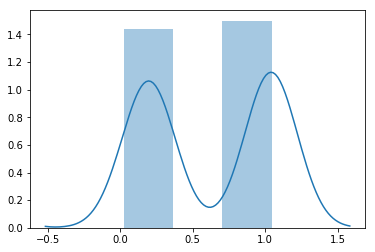

In [9]:
plot_results([x.fitness for x in res])

Since we are working in real-valued domain, we can use method like L-BFGS-B for fine tuning the results. Let's apply L-BFGS-B algorithm to final individuals of previous run and see, whether we can achieve improvement.

In [10]:
from scipy.optimize import minimize

opt_results = []
for index, individual in enumerate(res):
    print(index, end=', ')
    opt_res = minimize(cost_function, individual.genes, method='L-BFGS-B', bounds=[(0, b) for b in bounds])#, options={'eps': 1})
    opt_results.append(opt_res.fun)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

mean: 0.6625615182034497
median: 1.040461951472441
variance: 0.21300912491435373
min: 0.022010233340289852


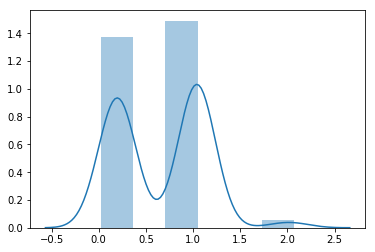

In [11]:
plot_results(opt_results)

Slight improvement was achieved.However it is clear, that we get stuck in local optima quite frequently. Also, since minimum value of this run is actually higher, than minimum value of simple_es run, it seems that we are stuck at local optima here too.

In order to prefer exploration, we need to add more perturbation to the search process. Few options there:

- use variant of single mutation for RVCGP - this will increase the number of changed genes, therefore hopefully increase the exploration
- add blend crossover to current fucking hillclimber heuristic

## Blend crossover within dumb hillclimber

In [78]:
random.seed(42)

Individual = rv_params.individual_class

indices = list(range(len(bounds)))
res = []

for trial in range(100):
    print(trial, end=', ')
    
    population = [Individual([random.uniform(0, b) for b in bounds], bounds, rv_params) for _ in range(20)]

    # evaluated the first population
    for individual in population:
        individual.fitness = cost_function(individual)

    #print('first best individual', min(population, key=lambda x: x.fitness))

    n_evals = 0

    while n_evals < 5000:
        parent = min(population, key=lambda x: x.fitness)

        new_population = []

        # generate new population by means of crossover
        for _ in range(10):
            # tournament selection and blending
            parent_a, parent_b = tools.selTournament(population, 2, 5)
            a, b = tools.cxBlend(parent_a.genes[:], parent_b.genes[:], 1)
            for genes in [a, b]:
                if random.random() > 0.2:
                    index = random.choice(indices)
                    genes[index] = random.uniform(0, bounds[index])
                    
            child_a = Individual(clip(a, bounds), bounds, rv_params)
            child_b = Individual(clip(b, bounds), bounds, rv_params)
            for ind in [child_a, child_b]:
                ind.fitness = cost_function(individual)
                n_evals += 1
                new_population += [child_a, child_b]

        new_population += [parent]
        population = new_population
    res.append(sorted(population, key=lambda x: x.fitness)[0])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

mean: 1.8420536903623685
median: 1.9495804286633966
variance: 0.18934613458834643
min: 0.33131569387455995


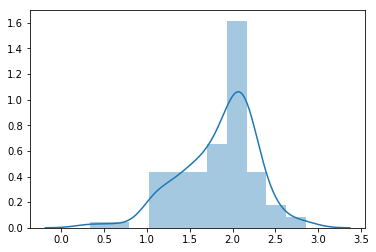

In [79]:
plot_results([x.fitness for x in res])

mean: 1.8614395842283462
median: 1.8551453540824347
variance: 0.1119554693384722
min: 1.0598822309812563


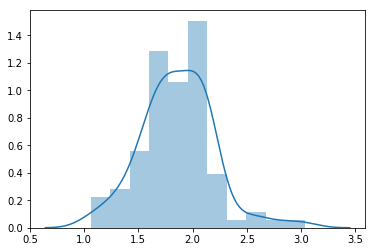

In [70]:
plot_results([x.fitness for x in res])

mean: 1.8144941426725207
median: 1.8079117129550342
variance: 0.10768616752438186
min: 1.1232321422611318


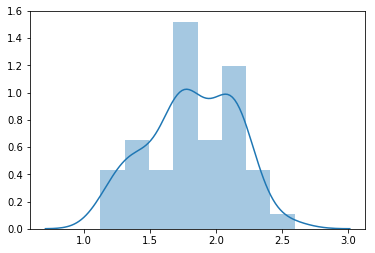

In [73]:
plot_results([x.fitness for x in res])

mean: 1.889244964613217
median: 1.9919616489718273
variance: 0.1365559784091294
min: 0.8018762828078548


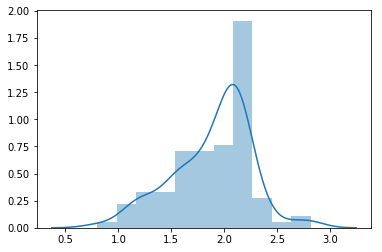

In [75]:
plot_results([x.fitness for x in res])

mean: 1.8138053251976987
median: 1.8067956165444325
variance: 0.1502584257917639
min: 1.0411720283538108


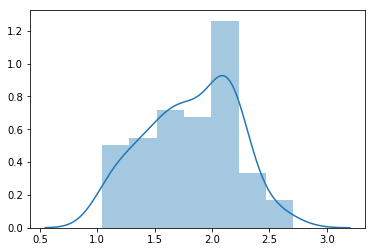

In [77]:
plot_results([x.fitness for x in res])

In [22]:
from deap import tools

In [60]:
population = [Individual([random.uniform(0, b) for b in bounds], bounds, rv_params) for _ in range(5)]

# evaluated the first population
for individual in population:
    individual.fitness = cost_function(individual)

In [61]:
parent_a, parent_b = tools.selTournament(population, 2, 5)
print(parent_a, parent_b)

Program, f:4.873612866736562 Program, f:3.4998468170044914


In [62]:
a, b = tools.cxBlend(parent_a.genes[:], parent_b.genes[:], 1)
child_a = Individual(clip(a, bounds), bounds, rv_params)
child_b = Individual(clip(b, bounds), bounds, rv_params)
for ind in [child_a, child_b]:
    ind.fitness = cost_function(individual)
print(child_a, child_b)

Program, f:4.873612866736562 Program, f:4.873612866736562


[Program, f:4.861871666706664, Program, f:4.861871666706664]

Hyperparameters

In [34]:
POPULATION_SIZE = 50

Create the initial population and evaluate it

In [164]:
from array import array
from deap import creator, base, tools, cma, algorithms

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array, typecode='f', fitness=creator.FitnessMin)

In [178]:
cost_function_cma(hof[0])

(1.0404619516475269,)